# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this 
business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

**Business objectives:** What are the key drivers for used car prices? What are the factors that make a car more or less expensive and can therefore be seen as more or less valuable for the consumer?

**Business Success Critiera:** Understand the top factors that make a car more valuable for a consumer so that the dealer can focus on holding cars with those features in the inventory at a higher ratio of overall inventory

**Requirements:** Project to be completed by November 20th at 9AM PT. Results will be displayed in a way that is easy to understand for non-data science individuals.

**Assumptions:** Data is assumed to be accurate and collected without substantial bias. Assumed the dataset sample is a representative sample of the 3M overall cars dataset. Also assume that the car sales are similar across states and regions.

**Constaints**: Data set is limited to 426K lines in order to speed processing. This analysis is also contrained by the data-scientists' current knowledge of data processing and tools for regressions. Ideally we would know what region our client car dealership is in, but unfortunately we don't so we must be constrained on looking at specific geographies, and will instead look at all geographies in aggregate rather than specific geos our client is in.

**Data Mining Goals:** Determine the features (e.g., model, condition, enginge size, fuel type, transmission) that are most valued by customers, what increase or decrease in value can be attributed to each feature, and how does value change when features are present with each other in combination. We may also want to isolate based on geography or fuel or condition. Success criteria is a generalized model with lowest possible mean squared error (MSE) in the test data-set across multiple model types (e.g., linear regression to nth polynomial, regularization with Ridge and Lasso, feature selection, and cross validation). This will also include a clear focus on the features selected and the level of impact that feature has on overall price (e.g., sequential feature selection and interpretation of coefficients). MSE is chosen because it should provide most relevant error term for regressions with so many categorical variables.

**Project Plan:** <br>
(1) Data Understanding: determine where there are nulls, unhelpful, or false data to be removed and determine variables that are numeric or categorical.<br>
(2) Data Preparation: remove nulls, split data into train and test datasets, create one-hot and other variable sets so that regression can be done on categorical variables.<br>
(3) Modeling: Will use a variety of modeling techniques including linear regression, LASSO and RIDGE regression with feature selection and different hyperparameters using GridSearch, and k-fold cross validation. <br>
(4) Evalation: Evaluation of the modeling will be done using a combination of MSE values for each type of regression and visual assessment of model generalizability. <br>
(5) Deployment: Deployment will be done by summarizing findings (in an easy to digest way) on which features are most impactful and their relative impact so that the dealer can prioritize for those features and in that order of importance. 

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [12]:
#import relavent tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn import set_config

set_config(display="diagram")


In [16]:
#load dataset
raw_data = pd.read_csv('data/vehicles.csv')
raw_data = pd.DataFrame(raw_data)
raw_data

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426875,7301591192,wyoming,23590,2019.0,nissan,maxima s sedan 4d,good,6 cylinders,gas,32226.0,clean,other,1N4AA6AV6KC367801,fwd,NaN,sedan,NaN,wy
426876,7301591187,wyoming,30590,2020.0,volvo,s60 t5 momentum sedan 4d,good,NaN,gas,12029.0,clean,other,7JR102FKXLG042696,fwd,NaN,sedan,red,wy
426877,7301591147,wyoming,34990,2020.0,cadillac,xt4 sport suv 4d,good,NaN,diesel,4174.0,clean,other,1GYFZFR46LF088296,NaN,NaN,hatchback,white,wy
426878,7301591140,wyoming,28990,2018.0,lexus,es 350 sedan 4d,good,6 cylinders,gas,30112.0,clean,other,58ABK1GG4JU103853,fwd,NaN,sedan,silver,wy


In [18]:
raw_data.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


First thing to notice is that there are definitley some outliers on the price so we'll want to take care of those as there is at least one car selling for a billion dollars and is likely significantly skewing the mean

In [21]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [23]:
#helpful to look at the unique values and the instances of those for each category to understand what is in each and what will be helpful for modeling
categorical_features = ['year','manufacturer','model','condition','cylinders','fuel','title_status','transmission','drive','size','type','paint_color']
numeric_features = ['odometer']
for feature in categorical_features:
    print(raw_data[feature].value_counts())

year
2017.0    36420
2018.0    36369
2015.0    31538
2013.0    30794
2016.0    30434
          ...  
1943.0        1
1915.0        1
1902.0        1
1905.0        1
1909.0        1
Name: count, Length: 114, dtype: int64
manufacturer
ford               70985
chevrolet          55064
toyota             34202
honda              21269
nissan             19067
jeep               19014
ram                18342
gmc                16785
bmw                14699
dodge              13707
mercedes-benz      11817
hyundai            10338
subaru              9495
volkswagen          9345
kia                 8457
lexus               8200
audi                7573
cadillac            6953
chrysler            6031
acura               5978
buick               5501
mazda               5427
infiniti            4802
lincoln             4220
volvo               3374
mitsubishi          3292
mini                2376
pontiac             2288
rover               2113
jaguar              1946
porsche          

**Data Understanding:** As we can see, there are quite a full nulls in the data. Of the 427K rows, only id, region, price, and state have any non-null values. Of particular concern is that "condition" and "size" have only 252K and 120K non-null values, and both of which would be assumed important for final price of the vehicle, particularly the "condition". We determine what the impacts of dropping all NA is on the entire dataset and decide if we should leave out features with high NA in the column.

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [27]:
data_drop = raw_data.dropna()
data_drop.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34868 entries, 126 to 426836
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            34868 non-null  int64  
 1   region        34868 non-null  object 
 2   price         34868 non-null  int64  
 3   year          34868 non-null  float64
 4   manufacturer  34868 non-null  object 
 5   model         34868 non-null  object 
 6   condition     34868 non-null  object 
 7   cylinders     34868 non-null  object 
 8   fuel          34868 non-null  object 
 9   odometer      34868 non-null  float64
 10  title_status  34868 non-null  object 
 11  transmission  34868 non-null  object 
 12  VIN           34868 non-null  object 
 13  drive         34868 non-null  object 
 14  size          34868 non-null  object 
 15  type          34868 non-null  object 
 16  paint_color   34868 non-null  object 
 17  state         34868 non-null  object 
dtypes: float64(2), int64(2), obj

We've lost all but 35K records, less than 10% of our original dataset. That's probably too much of the dataset to drop and we can have a more accurate and useful model if we drop a few of the columns with large missing NA values. Since condition is probably important to the final price, we will keep that. So, we must drop 'size' due to NA amount (since that's likely very correlated with 'type'), as well as cylinders (lots of NA and not likely to be that important to customers or will be correlated to vehicle type), as well as model (way too many unique variables, with plenty of inconsistencies across names to make it all but unusable for regression as a categorical variable e.g., "Silverado", "Silverado 1500", "1500" all referring to the same or similar cars but with different naming). While we're at it we can also drop VIN (no useful info), and region/state (assume cars sold per region are similar across regions so geographic differences in overall cost are modeled equally). We can also drop ID because it will not be used for modeling.

In [30]:
data_drop = raw_data.drop(columns=['size','VIN','region','state','model','id','cylinders'])
data_drop = data_drop.dropna()
data_drop.info()

<class 'pandas.core.frame.DataFrame'>
Index: 143333 entries, 31 to 426878
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         143333 non-null  int64  
 1   year          143333 non-null  float64
 2   manufacturer  143333 non-null  object 
 3   condition     143333 non-null  object 
 4   fuel          143333 non-null  object 
 5   odometer      143333 non-null  float64
 6   title_status  143333 non-null  object 
 7   transmission  143333 non-null  object 
 8   drive         143333 non-null  object 
 9   type          143333 non-null  object 
 10  paint_color   143333 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 13.1+ MB


We've now shrunk our dataset to 143K cars sold, which is still only 33% of the original datset but likely enough to go on to create a more accurate model. We'll revisit this if needed when modeling.

In [35]:
#now we can look at the unique values for both the reduced data set and the orignal to ensure we see similar ratios of each categorical variable
#This is a quick eyeball test to make sure we're not skewing the data siginificantly
categorical_features = ['year','manufacturer','condition','fuel','title_status','transmission','drive','type','paint_color']
numeric_features = ['odometer']
for feature in categorical_features:
    print(data_drop[feature].value_counts())
    print(raw_data[feature].value_counts())

year
2017.0    10583
2013.0    10555
2018.0     9742
2016.0     9548
2014.0     9490
          ...  
1918.0        1
1922.0        1
1905.0        1
1916.0        1
1944.0        1
Name: count, Length: 104, dtype: int64
year
2017.0    36420
2018.0    36369
2015.0    31538
2013.0    30794
2016.0    30434
          ...  
1943.0        1
1915.0        1
1902.0        1
1905.0        1
1909.0        1
Name: count, Length: 114, dtype: int64
manufacturer
ford               23973
chevrolet          20433
toyota             12084
honda               8114
nissan              7314
jeep                6633
gmc                 5446
bmw                 5033
dodge               4850
ram                 4724
volkswagen          4100
hyundai             3868
mercedes-benz       3668
subaru              3104
kia                 3037
lexus               2891
mazda               2261
cadillac            2234
chrysler            2230
buick               2071
acura               1935
lincoln             17

In general, the ratios and ordering of values within each feature appears to be approximately similar across both data sets (expcept possibly the drive feature which has more 4wd removed from the data set proportionally vs. fwd and rwd, as well as the title_status which ahs more 'clean' and 'missing' removed proportionally). 

In [38]:
#Because year is a categorical variable right now, we should translate that to something we can more easily calculate numerically
data_drop['age'] = 2024 - data_drop['year']
print(data_drop)

        price    year   manufacturer  condition fuel  odometer title_status  \
31      15000  2013.0           ford  excellent  gas  128000.0        clean   
32      27990  2012.0            gmc       good  gas   68696.0        clean   
33      34590  2016.0      chevrolet       good  gas   29499.0        clean   
34      35000  2019.0         toyota  excellent  gas   43000.0        clean   
35      29990  2016.0      chevrolet       good  gas   17302.0        clean   
...       ...     ...            ...        ...  ...       ...          ...   
426872  32590  2020.0  mercedes-benz       good  gas   19059.0        clean   
426873  30990  2018.0  mercedes-benz       good  gas   15080.0        clean   
426874  33590  2018.0          lexus       good  gas   30814.0        clean   
426876  30590  2020.0          volvo       good  gas   12029.0        clean   
426878  28990  2018.0          lexus       good  gas   30112.0        clean   

       transmission drive    type paint_color   age

In [40]:
#now we can drop year from categorical values and add age to numeric features
categorical_features = ['manufacturer','condition','fuel','title_status','transmission','drive','type','paint_color']
numeric_features = ['odometer','age']
data_no_year = data_drop.drop('year',axis=1)

In [42]:
data_no_year.info()

<class 'pandas.core.frame.DataFrame'>
Index: 143333 entries, 31 to 426878
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         143333 non-null  int64  
 1   manufacturer  143333 non-null  object 
 2   condition     143333 non-null  object 
 3   fuel          143333 non-null  object 
 4   odometer      143333 non-null  float64
 5   title_status  143333 non-null  object 
 6   transmission  143333 non-null  object 
 7   drive         143333 non-null  object 
 8   type          143333 non-null  object 
 9   paint_color   143333 non-null  object 
 10  age           143333 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 13.1+ MB


In [746]:
#we can also recategorize our manufacturers to cut down on compute power needed and hopefully improve overfitting across so many categorical variables
manufacturer_mapping = {
    'ford':'domestic',
    'gmc':'domestic',
    'chevrolet':'domestic',
    'dodge':'domestic',
    'ram':'domestic',
    'chrysler':'domestic',
    'mercury':'domestic',
    'saturn':'domestic',
    'tesla':'domestic',
    'jeep':'domestic',
    'pontiac':'domestic',
    'toyota':'foreign',
    'honda':'foreign',
    'nissan':'foreign',
    'volkswagen':'foreign',
    'hyundai':'foreign',
    'subaru':'foreign',
    'kia':'foreign',
    'mazda':'foreign',
    'mitsubishi':'foreign',
    'mini':'foreign',
    'rover':'foreign',
    'jaguar':'foreign',
    'bmw':'foreign luxury',
    'mercedes-benz':'foreign luxury',
    'lexus':'foreign luxury',
    'acura':'foreign luxury',
    'audi':'foreign luxury',
    'volvo':'foreign luxury',
    'porsche':'foreign luxury',
    'alfa-romeo':'foreign luxury',
    'ferrari':'super',
    'land rover':'foreign luxury',
    'aston-martin':'super',
    'cadillac':'domestic luxury',
    'buick':'domestic',
    'lincoln':'domestic luxury',
    'infiniti':'foreign luxury',
    'fiat':'foreign'
}

data_no_year['manufacturer_category'] = data_no_year['manufacturer'].map(manufacturer_mapping).fillna('other')
df_no_manufacturer = data_no_year.drop('manufacturer',axis=1)
categorical_features = ['manufacturer_category','condition','fuel','title_status','transmission','drive','type','paint_color']

In [46]:
df_no_manufacturer

,price,condition,fuel,odometer,title_status,transmission,drive,type,paint_color,age,manufacturer_category
31,15000,excellent,gas,128000.0,clean,automatic,rwd,truck,black,11.0,domestic
32,27990,good,gas,68696.0,clean,other,4wd,pickup,black,12.0,domestic
33,34590,good,gas,29499.0,clean,other,4wd,pickup,silver,8.0,domestic
34,35000,excellent,gas,43000.0,clean,automatic,4wd,truck,grey,5.0,foreign
35,29990,good,gas,17302.0,clean,other,4wd,pickup,red,8.0,domestic
...,...,...,...,...,...,...,...,...,...,...,...
426872,32590,good,gas,19059.0,clean,other,rwd,sedan,white,4.0,foreign luxury
426873,30990,good,gas,15080.0,clean,automatic,rwd,other,white,6.0,foreign luxury
426874,33590,good,gas,30814.0,clean,automatic,rwd,sedan,white,6.0,foreign luxury
426876,30590,good,gas,12029.0,clean,other,fwd,sedan,red,4.0,foreign luxury


Now we have dropped manufacturer from the dataset and reclassified as one of 5 other categories: domestic, foreign, domestic luxury, foreign luxury, or super (or other). Now we can convert the ordinal categorical feature "condition" to numeric values because it appears roughly linear.

Text(0.5, 1.0, 'Condition of car by car sales')

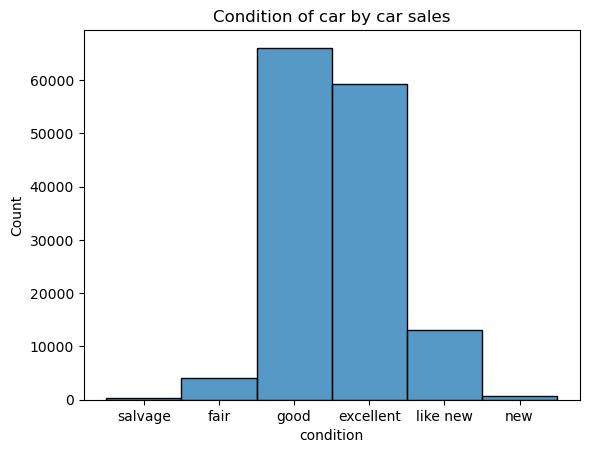

In [49]:
#plot condition to ensure it is roughly normal
condition_order = ['salvage','fair','good','excellent','like new','new']
df_no_manufacturer['condition'] = pd.Categorical(df_no_manufacturer['condition'], categories = condition_order, ordered=True)
sns.histplot(df_no_manufacturer['condition'], discrete = True)
plt.title('Condition of car by car sales')

In [51]:
#since the ordinal values are roughly linear, we can use numerical values for the ordinal ones, that will help us keep down our categorical values
df_no_manufacturer['condition_numeric'] = df_no_manufacturer['condition'].cat.codes
print(df_no_manufacturer['condition_numeric'].value_counts())

condition_numeric
2    66039
3    59265
4    13021
1     4043
5      645
0      320
Name: count, dtype: int64


In [53]:
df_num_condition = df_no_manufacturer.drop('condition',axis=1)

In [55]:
#update categorical feature names again
categorical_features = ['manufacturer_category','fuel','title_status','transmission','drive','type','paint_color']
numeric_features = ['odometer','age','condition_numeric']

In [57]:
#like the manufacturing mapping, the type should also be mapped to smaller categories to reduce onehot encoding variables
type_mapping = {
    'sedan':'compact',
    'SUV':'SUV',
    'pickup':'truck',
    'truck':'truck',
    'other':'other',
    'coupe':'compact',
    'hatchback':'compact',
    'wagon':'compact',
    'van':'van',
    'convertible':'convertible',
    'mini-van':'van',
    'offroad':'other',
    'bus':'other',
}

In [59]:
#now replace all type with type_category
df_num_condition['type_category'] = df_num_condition['type'].map(type_mapping).fillna('other')
df_no_type = df_num_condition.drop('type',axis=1)
categorical_features = ['manufacturer_category','fuel','title_status','transmission','drive','type_category','paint_color']

In [61]:
df_no_type

,price,fuel,odometer,title_status,transmission,drive,paint_color,age,manufacturer_category,condition_numeric,type_category
31,15000,gas,128000.0,clean,automatic,rwd,black,11.0,domestic,3,truck
32,27990,gas,68696.0,clean,other,4wd,black,12.0,domestic,2,truck
33,34590,gas,29499.0,clean,other,4wd,silver,8.0,domestic,2,truck
34,35000,gas,43000.0,clean,automatic,4wd,grey,5.0,foreign,3,truck
35,29990,gas,17302.0,clean,other,4wd,red,8.0,domestic,2,truck
...,...,...,...,...,...,...,...,...,...,...,...
426872,32590,gas,19059.0,clean,other,rwd,white,4.0,foreign luxury,2,compact
426873,30990,gas,15080.0,clean,automatic,rwd,white,6.0,foreign luxury,2,other
426874,33590,gas,30814.0,clean,automatic,rwd,white,6.0,foreign luxury,2,compact
426876,30590,gas,12029.0,clean,other,fwd,red,4.0,foreign luxury,2,compact


In [63]:
df_no_type.info()

<class 'pandas.core.frame.DataFrame'>
Index: 143333 entries, 31 to 426878
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   price                  143333 non-null  int64  
 1   fuel                   143333 non-null  object 
 2   odometer               143333 non-null  float64
 3   title_status           143333 non-null  object 
 4   transmission           143333 non-null  object 
 5   drive                  143333 non-null  object 
 6   paint_color            143333 non-null  object 
 7   age                    143333 non-null  float64
 8   manufacturer_category  143333 non-null  object 
 9   condition_numeric      143333 non-null  int8   
 10  type_category          143333 non-null  object 
dtypes: float64(2), int64(1), int8(1), object(7)
memory usage: 12.2+ MB


In [65]:
for feature in categorical_features:
    print(df_no_type[feature].value_counts())

manufacturer_category
domestic           72778
foreign            47853
foreign luxury     18607
domestic luxury     4002
other                 63
super                 30
Name: count, dtype: int64
fuel
gas         125103
other         8010
diesel        7302
hybrid        2160
electric       758
Name: count, dtype: int64
title_status
clean         136990
rebuilt         3627
salvage         1500
lien             928
missing          227
parts only        61
Name: count, dtype: int64
transmission
automatic    107665
other         26582
manual         9086
Name: count, dtype: int64
drive
4wd    56328
fwd    53592
rwd    33413
Name: count, dtype: int64
type_category
compact        62270
truck          32266
SUV            31377
van             6740
other           6585
convertible     4095
Name: count, dtype: int64
paint_color
white     34838
black     29256
silver    20560
red       15936
blue      15929
grey      13774
green      4133
brown      3858
custom     2667
yellow     1077
ora

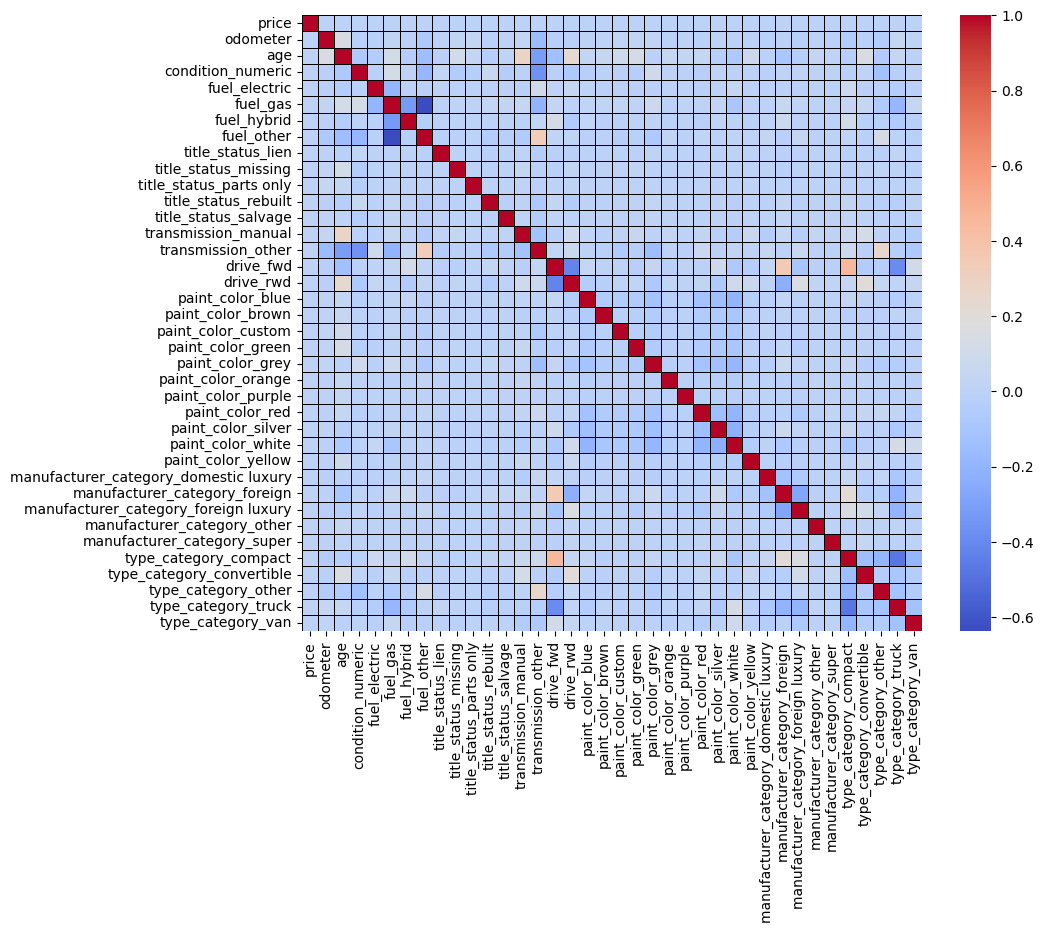

In [67]:
#Now determine if there is any correlation between features in the data
df_onehot = pd.get_dummies(df_no_type, drop_first=True)
corr = df_onehot.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr,annot=False, cmap='coolwarm', linewidths=0.5, linecolor='black',
            xticklabels=corr.columns, yticklabels=corr.columns)  # Consider turning off annotations for speed
plt.show()

Because there is high correlation within the categories "fuel_other" and "transmission_other" we should look further at what those types of cars are. We should also determine what's necessary to deal with the correlation within 'fwd' and 'rwd'. Since those are binary, and if the car isn't 4wd it has to be either rwd or fwd, we can add two boolean columns that so either 4wd (yes or no) or fwd (yes or no) and that provides all the info we need and also reduces our onehot columns. 

In [70]:
data_other_fuel = raw_data[raw_data['fuel'] == 'other']
print(data_other_fuel.info())
for feature in ['model','transmission']:
    print(data_other_fuel[feature].value_counts().head(15))

<class 'pandas.core.frame.DataFrame'>
Index: 30728 entries, 40 to 426869
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            30728 non-null  int64  
 1   region        30728 non-null  object 
 2   price         30728 non-null  int64  
 3   year          30717 non-null  float64
 4   manufacturer  29439 non-null  object 
 5   model         29998 non-null  object 
 6   condition     21526 non-null  object 
 7   cylinders     6803 non-null   object 
 8   fuel          30728 non-null  object 
 9   odometer      30637 non-null  float64
 10  title_status  30607 non-null  object 
 11  transmission  30620 non-null  object 
 12  VIN           28773 non-null  object 
 13  drive         16702 non-null  object 
 14  size          1521 non-null   object 
 15  type          28387 non-null  object 
 16  paint_color   22805 non-null  object 
 17  state         30728 non-null  object 
dtypes: float64(2), int64(2), obje

In [72]:
#fuel type 'other' doesn't tell us anything and there isn't much possible information on what other is. Luckily many tranmission other are
#also in  the fuel type 'other' rows
df_no_other_fuel = df_no_type.drop(df_no_type[df_no_type['fuel'] == 'other'].index)
df_no_other_transmission = df_no_other_fuel.drop(df_no_other_fuel[df_no_other_fuel['transmission'] == 'other'].index)

In [74]:
print(df_no_other_transmission.info())
print(df_no_other_transmission.head())

<class 'pandas.core.frame.DataFrame'>
Index: 114442 entries, 31 to 426874
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   price                  114442 non-null  int64  
 1   fuel                   114442 non-null  object 
 2   odometer               114442 non-null  float64
 3   title_status           114442 non-null  object 
 4   transmission           114442 non-null  object 
 5   drive                  114442 non-null  object 
 6   paint_color            114442 non-null  object 
 7   age                    114442 non-null  float64
 8   manufacturer_category  114442 non-null  object 
 9   condition_numeric      114442 non-null  int8   
 10  type_category          114442 non-null  object 
dtypes: float64(2), int64(1), int8(1), object(7)
memory usage: 9.7+ MB
None
    price    fuel  odometer title_status transmission drive paint_color   age  \
31  15000     gas  128000.0        clean    aut

In [76]:
df = df_no_other_transmission

In [78]:
for feature in categorical_features:
    print(df[feature].value_counts())

manufacturer_category
domestic           59707
foreign            38229
foreign luxury     13731
domestic luxury     2686
other                 63
super                 26
Name: count, dtype: int64
fuel
gas         105720
diesel        6926
hybrid        1553
electric       243
Name: count, dtype: int64
title_status
clean         108148
rebuilt         3609
salvage         1490
lien             921
missing          216
parts only        58
Name: count, dtype: int64
transmission
automatic    105396
manual         9046
Name: count, dtype: int64
drive
4wd    47447
fwd    42013
rwd    24982
Name: count, dtype: int64
type_category
compact        47479
SUV            28754
truck          26568
van             6177
convertible     3473
other           1991
Name: count, dtype: int64
paint_color
white     27296
black     21385
silver    16572
grey      13633
blue      12619
red       11493
green      3640
brown      3288
custom     2628
yellow      831
orange      709
purple      348
Name: coun

In [80]:
print(df)

        price    fuel  odometer title_status transmission drive paint_color  \
31      15000     gas  128000.0        clean    automatic   rwd       black   
34      35000     gas   43000.0        clean    automatic   4wd        grey   
55      19900  diesel   88000.0        clean    automatic   4wd        blue   
59      14000     gas   95000.0        clean    automatic   fwd      silver   
65      22500  diesel  144700.0        clean       manual   rwd       white   
...       ...     ...       ...          ...          ...   ...         ...   
426836      0  diesel   20492.0        clean    automatic   4wd       white   
426860  39990     gas   41664.0        clean    automatic   4wd       black   
426866  32990     gas   55612.0        clean    automatic   rwd       black   
426873  30990     gas   15080.0        clean    automatic   rwd       white   
426874  33590     gas   30814.0        clean    automatic   rwd       white   

         age manufacturer_category  condition_numer

**Now that we have close to a final dataset we can eliminate outliers if they still exist**

In [83]:
df.describe()

,price,odometer,age,condition_numeric
count,1.144420e+05,1.144420e+05,114442.000000,114442.000000
mean,6.124966e+04,1.194631e+05,15.115316,2.712920
std,1.154896e+07,2.246244e+05,9.845417,0.742219
min,0.000000e+00,0.000000e+00,2.000000,0.000000
25%,5.498000e+03,6.919375e+04,9.000000,2.000000
50%,9.995000e+03,1.100000e+05,13.000000,3.000000
75%,1.799900e+04,1.510000e+05,18.000000,3.000000
max,3.736929e+09,1.000000e+07,124.000000,5.000000


There is still at least one car price in the billions, as well as an odometer that is over a million miles (which is technically possible but can be eliminated)

In [86]:
largest_prices = df.nlargest(20, 'price')
print(largest_prices)

             price    fuel  odometer title_status transmission drive  \
318592  3736928711     gas  164000.0        clean    automatic   4wd   
29386   1111111111  diesel  149000.0        clean    automatic   rwd   
230753   135008900     gas  110500.0        clean    automatic   4wd   
137807   123456789     gas   96000.0        clean    automatic   fwd   
193736   123456789     gas   64181.0        clean    automatic   fwd   
307488   123456789     gas  320000.0        clean    automatic   4wd   
136516    17000000  diesel  170000.0      rebuilt    automatic   4wd   
286323    12345678     gas  100000.0        clean    automatic   4wd   
286324    12345678     gas  100000.0        clean    automatic   4wd   
288400    12345678     gas  100000.0        clean    automatic   4wd   
288401    12345678     gas  100000.0        clean    automatic   4wd   
303014    12345678     gas  100000.0        clean    automatic   4wd   
303644    12345678     gas  100000.0        clean    automatic  

This appears that there is a data entry issue where some prices are just "1111111111" or "123456789" which is skewing our data. This values will need to be removed. I will remove prices at and above $1,111,111 which will remove 16 cars

In [89]:
df = df[df['price'] < 1111111]
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 114426 entries, 31 to 426874
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   price                  114426 non-null  int64  
 1   fuel                   114426 non-null  object 
 2   odometer               114426 non-null  float64
 3   title_status           114426 non-null  object 
 4   transmission           114426 non-null  object 
 5   drive                  114426 non-null  object 
 6   paint_color            114426 non-null  object 
 7   age                    114426 non-null  float64
 8   manufacturer_category  114426 non-null  object 
 9   condition_numeric      114426 non-null  int8   
 10  type_category          114426 non-null  object 
dtypes: float64(2), int64(1), int8(1), object(7)
memory usage: 9.7+ MB
None


In [91]:
#do the same with odometer
largest_odometer = df.nlargest(60, 'odometer')
print(largest_odometer)

        price    fuel    odometer title_status transmission drive paint_color  \
28738   20000     gas  10000000.0        clean    automatic   rwd      custom   
44280   16000     gas  10000000.0        clean       manual   rwd         red   
151740    800     gas  10000000.0        clean       manual   rwd       black   
191629   7500     gas  10000000.0   parts only    automatic   rwd         red   
208157   9000     gas  10000000.0        clean    automatic   rwd         red   
260971   4000     gas  10000000.0        clean       manual   4wd       black   
262338   4800     gas  10000000.0      missing       manual   rwd        blue   
292399   1300     gas  10000000.0        clean    automatic   rwd         red   
305172   4500     gas  10000000.0        clean    automatic   rwd      custom   
1397        0  diesel   9999999.0        clean    automatic   4wd         red   
1398        0  diesel   9999999.0        clean    automatic   4wd         red   
1399        0     gas   9999

After looking at a few of these specific vehicles, it appears some are given a filler value of 10,000,000 which is highly unlikely to be true. Because of this, I will remove odometer values larger than 3,000,000. This will remove about 50 cars.

In [94]:
df = df[df['odometer'] < 3000000]
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 114368 entries, 31 to 426874
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   price                  114368 non-null  int64  
 1   fuel                   114368 non-null  object 
 2   odometer               114368 non-null  float64
 3   title_status           114368 non-null  object 
 4   transmission           114368 non-null  object 
 5   drive                  114368 non-null  object 
 6   paint_color            114368 non-null  object 
 7   age                    114368 non-null  float64
 8   manufacturer_category  114368 non-null  object 
 9   condition_numeric      114368 non-null  int8   
 10  type_category          114368 non-null  object 
dtypes: float64(2), int64(1), int8(1), object(7)
memory usage: 9.7+ MB
None


In [96]:
#check the summary stats to see how removing outliers impacts summary statistics
df.describe()

,price,odometer,age,condition_numeric
count,114368.000000,1.143680e+05,114368.000000,114368.000000
mean,13644.402543,1.148222e+05,15.106061,2.713172
std,12377.612167,8.087311e+04,9.826247,0.741720
min,0.000000,0.000000e+00,2.000000,0.000000
25%,5499.000000,6.911150e+04,9.000000,2.000000
50%,9995.000000,1.100000e+05,13.000000,3.000000
75%,17999.000000,1.510000e+05,18.000000,3.000000
max,195000.000000,2.915272e+06,124.000000,5.000000


We have now substantially reduced our standard deviation and max values for price and odometer. We should also check the maximum value for age and lowest values for price.

In [99]:
#do the same with age
oldest_cars = df.nlargest(100, 'age')
print(oldest_cars)

        price fuel  odometer title_status transmission drive paint_color  \
42454   38250  gas    4500.0        clean    automatic   4wd      silver   
289145   3990  gas  202570.0        clean    automatic   rwd       white   
54732   85000  gas     150.0        clean       manual   rwd       black   
350783  12000  gas   30000.0      missing       manual   rwd       black   
26712   16000  gas   56000.0        clean    automatic   rwd         red   
...       ...  ...       ...          ...          ...   ...         ...   
239130  16500  gas     100.0        clean       manual   rwd       brown   
284432  18500  gas   47510.0        clean       manual   rwd       brown   
293099  14900  gas    1100.0        clean    automatic   rwd         red   
294919  16200  gas    1100.0        clean    automatic   rwd         red   
347526   7500  gas     500.0      missing       manual   rwd       green   

          age manufacturer_category  condition_numeric type_category  
42454   124.0   

In order to make an informed opinion on age, a histogram is needed. Additionally, because we are trying to sell used cars today, we should probably car about the types of cars likely to be on our lots. If we don't sell classic, historic cars, we should only focus on more modern cars (maybe in the last 30 years). 

Text(0.5, 1.0, 'Car Age by number of cars sold')

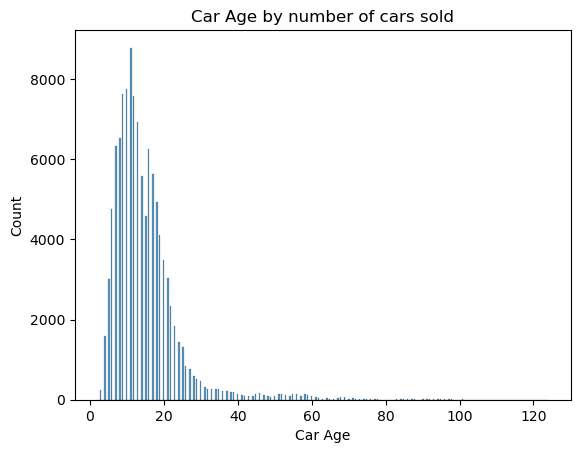

In [102]:
sns.histplot(df['age'])
plt.xlabel('Car Age')
plt.title('Car Age by number of cars sold')

Considering automatic cars weren't even mass produced until 1939 (age 85) there's no way the age on these cars is accurate with so many automatics. I will remove data that has age > 30 years old. This will remove about 5,400 cars sold.

In [105]:
df = df[df['age'] <= 30]
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 108876 entries, 31 to 426874
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   price                  108876 non-null  int64  
 1   fuel                   108876 non-null  object 
 2   odometer               108876 non-null  float64
 3   title_status           108876 non-null  object 
 4   transmission           108876 non-null  object 
 5   drive                  108876 non-null  object 
 6   paint_color            108876 non-null  object 
 7   age                    108876 non-null  float64
 8   manufacturer_category  108876 non-null  object 
 9   condition_numeric      108876 non-null  int8   
 10  type_category          108876 non-null  object 
dtypes: float64(2), int64(1), int8(1), object(7)
memory usage: 9.2+ MB
None


Last step for dealing with outliers is to look at cars with 0 or very low prices.

In [108]:
smallest_price = df.nsmallest(5200, 'price')
print(smallest_price)

        price fuel  odometer title_status transmission drive paint_color  \
126         0  gas   68472.0        clean    automatic   rwd       white   
127         0  gas   69125.0        clean    automatic   rwd       white   
128         0  gas   66555.0        clean    automatic   rwd       white   
191         0  gas   99505.0        clean    automatic   fwd      silver   
239         0  gas   25127.0        clean    automatic   4wd         red   
...       ...  ...       ...          ...          ...   ...         ...   
332226    100  gas   40969.0        clean    automatic   fwd       white   
332262    100  gas  104667.0        clean    automatic   fwd       black   
332840    100  gas   38997.0        clean    automatic   fwd       white   
333890    100  gas   38997.0        clean    automatic   fwd       white   
338429    100  gas   38996.0        clean    automatic   fwd         red   

         age manufacturer_category  condition_numeric type_category  
126      6.0     

Looking at the data, the most reasonable price cut-off appears to be 100. This may still be low but at least it removes the 1000s of cars that were sold for 0 that will skew the regressions. This removes another 5k cars. 

In [111]:
df = df[df['price'] > 100]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 103660 entries, 31 to 426874
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   price                  103660 non-null  int64  
 1   fuel                   103660 non-null  object 
 2   odometer               103660 non-null  float64
 3   title_status           103660 non-null  object 
 4   transmission           103660 non-null  object 
 5   drive                  103660 non-null  object 
 6   paint_color            103660 non-null  object 
 7   age                    103660 non-null  float64
 8   manufacturer_category  103660 non-null  object 
 9   condition_numeric      103660 non-null  int8   
 10  type_category          103660 non-null  object 
dtypes: float64(2), int64(1), int8(1), object(7)
memory usage: 8.8+ MB


In [113]:
#check the summary statistics to see how stddev and max and min has changed
df.describe()

,price,odometer,age,condition_numeric
count,103660.000000,1.036600e+05,103660.000000,103660.000000
mean,14332.662242,1.169128e+05,13.587546,2.718908
std,12202.705927,7.803095e+04,5.599831,0.734648
min,101.000000,0.000000e+00,2.000000,0.000000
25%,5995.000000,7.244725e+04,9.000000,2.000000
50%,10500.000000,1.130000e+05,13.000000,3.000000
75%,18900.000000,1.530478e+05,17.000000,3.000000
max,195000.000000,2.915272e+06,30.000000,5.000000


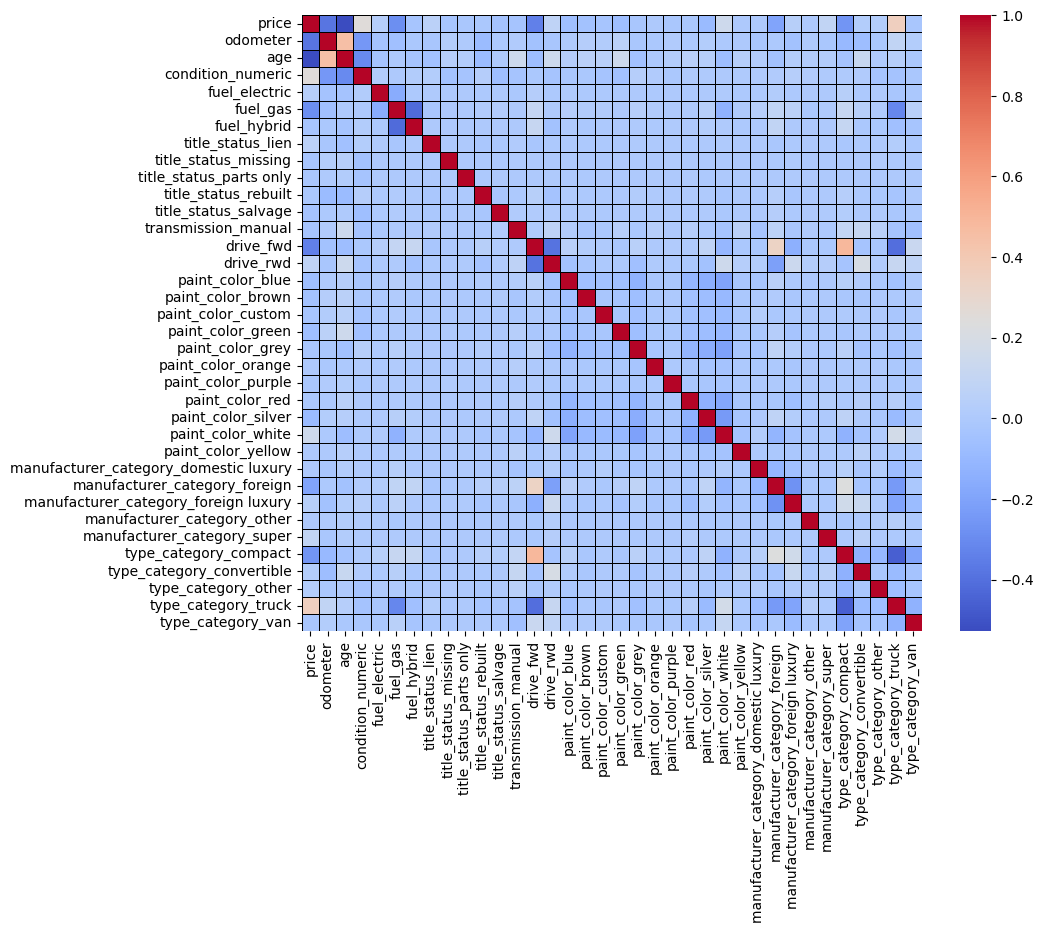

In [115]:
#perform one more correlation look to ensure we don't have collinearity messing with the modeling
df_onehot_final = pd.get_dummies(df, drop_first=True)
corr_final = df_onehot_final.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_final,annot=False, cmap='coolwarm', linewidths=0.5, linecolor='black',
            xticklabels=corr_final.columns, yticklabels=corr_final.columns)  # Consider turning off annotations for speed
plt.show()

This correlation matrix gives us the start of a clearer picture on what drives price, specifically seeing age, drive, type (especially truck and compact), and condition could have a strong impact on the price of the vehicle.

We now have our full dataframe to work from. From this we will now need to perform a variety of actions to modify the categorical variables and standardize the values so that we can perform regression on the data, but we will include those in the pipelines that we will use for modeling. 

In [119]:
df_final = df
df_final

,price,fuel,odometer,title_status,transmission,drive,paint_color,age,manufacturer_category,condition_numeric,type_category
31,15000,gas,128000.0,clean,automatic,rwd,black,11.0,domestic,3,truck
34,35000,gas,43000.0,clean,automatic,4wd,grey,5.0,foreign,3,truck
55,19900,diesel,88000.0,clean,automatic,4wd,blue,20.0,domestic,2,truck
59,14000,gas,95000.0,clean,automatic,fwd,silver,12.0,foreign,3,van
65,22500,diesel,144700.0,clean,manual,rwd,white,23.0,domestic,2,truck
...,...,...,...,...,...,...,...,...,...,...,...
426833,6800,gas,69550.0,clean,automatic,rwd,white,27.0,foreign,2,convertible
426860,39990,gas,41664.0,clean,automatic,4wd,black,7.0,foreign luxury,2,other
426866,32990,gas,55612.0,clean,automatic,rwd,black,8.0,foreign luxury,2,other
426873,30990,gas,15080.0,clean,automatic,rwd,white,6.0,foreign luxury,2,other


In [121]:
df_final = df_final.reset_index(drop = True)
df_final

,price,fuel,odometer,title_status,transmission,drive,paint_color,age,manufacturer_category,condition_numeric,type_category
0,15000,gas,128000.0,clean,automatic,rwd,black,11.0,domestic,3,truck
1,35000,gas,43000.0,clean,automatic,4wd,grey,5.0,foreign,3,truck
2,19900,diesel,88000.0,clean,automatic,4wd,blue,20.0,domestic,2,truck
3,14000,gas,95000.0,clean,automatic,fwd,silver,12.0,foreign,3,van
4,22500,diesel,144700.0,clean,manual,rwd,white,23.0,domestic,2,truck
...,...,...,...,...,...,...,...,...,...,...,...
103655,6800,gas,69550.0,clean,automatic,rwd,white,27.0,foreign,2,convertible
103656,39990,gas,41664.0,clean,automatic,4wd,black,7.0,foreign luxury,2,other
103657,32990,gas,55612.0,clean,automatic,rwd,black,8.0,foreign luxury,2,other
103658,30990,gas,15080.0,clean,automatic,rwd,white,6.0,foreign luxury,2,other


In [272]:
#split data into training/validation and Final Test data, 20% withheld for final test
X_train_val, X_test, y_train_val, y_test = train_test_split(df_final.drop('price',axis=1), df_final['price'], test_size = 0.2)

In [274]:
#split training and validation data into train, validation. Split 25% so that train/val/test data is 60/20/20
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.25)
print(f"training set: {len(X_train)}")
print(f"validation set: {len(X_val)}")
print(f"test set: {len(X_test)}")

training set: 62196
validation set: 20732
test set: 20732


In [767]:
#next we make the preprocessor that can be used in the pipelines of the modeling. In this case we need to modify the categorical columns defined earlier
#through OneHot, as well as scale the odometer feature so that coefficients can be interpreted more easily

categorical_features = ['manufacturer_category','fuel','title_status','transmission','drive','type_category','paint_color']
numeric_features = ['odometer','age','condition_numeric']

preprocessor = ColumnTransformer(
    transformers = [
        ('dummies', OneHotEncoder(), categorical_features),
        ('scaler', StandardScaler(), numeric_features)
    ]
)

In [278]:
X_train.head()

,fuel,odometer,title_status,transmission,drive,paint_color,age,manufacturer_category,condition_numeric,type_category
70608,diesel,93850.0,clean,automatic,4wd,grey,13.0,domestic,2,truck
76942,diesel,244918.0,clean,automatic,rwd,white,19.0,domestic,2,truck
76968,gas,101335.0,clean,automatic,4wd,white,11.0,domestic,2,truck
93715,gas,171000.0,clean,automatic,fwd,grey,24.0,foreign,2,SUV
80699,gas,110598.0,clean,automatic,fwd,grey,12.0,foreign,3,compact


In [280]:
#double check the preprocessor works as intended
X_train_transformed = preprocessor.fit_transform(X_train)
feature_names_transformed = list(preprocessor.transformers_[0][1].get_feature_names_out(categorical_features)) + list(numeric_features)
X_train_transformed_df = pd.DataFrame(X_train_transformed.toarray(), columns = feature_names_transformed)
print(X_train_transformed_df.head(10))

   manufacturer_category_domestic  manufacturer_category_domestic luxury  \
0                             1.0                                    0.0   
1                             1.0                                    0.0   
2                             1.0                                    0.0   
3                             0.0                                    0.0   
4                             0.0                                    0.0   
5                             1.0                                    0.0   
6                             0.0                                    0.0   
7                             1.0                                    0.0   
8                             1.0                                    0.0   
9                             1.0                                    0.0   

   manufacturer_category_foreign  manufacturer_category_foreign luxury  \
0                            0.0                                   0.0   
1              

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

**Determine best polynomial model fit and iterate to determine lowest MSE**

In [311]:
#first set up list to store cross validation MSE for each degree polynomial
cv_scores_train = {f'degree_{i}': None for i in range(1,5)}
cv_scores_val = {f'degree_{i}': None for i in range(1,5)}

#because the onehot encoding creates so many columns for many unique value features, higher order polynomial requires too much compute to attempt
for i in range(1,5):
    linear_pipe = Pipeline([
        ('processer',preprocessor),
        ('poly',PolynomialFeatures(degree = i, include_bias=False)),
        ('linreg',LinearRegression())
    ])

    #perform regression and fit on the training data
    linear_pipe.fit(X_train, y_train)
    #save the test MSE as we're looking for predictive power
    cv_scores_train[f'degree_{i}'] = mean_squared_error(y_train,linear_pipe.predict(X_train))
    cv_scores_val[f'degree_{i}'] = mean_squared_error(y_val,linear_pipe.predict(X_val))
print(f'mse for training: {cv_scores_train}')
print(f'mse for test: {cv_scores_val}')

mse for training: {'degree_1': 57540853.199307226, 'degree_2': 37842424.66106814, 'degree_3': 32223510.22395266, 'degree_4': 31478037.446375173}
mse for test: {'degree_1': 63589760.15328893, 'degree_2': 43981403.10252687, 'degree_3': 60395819.634626836, 'degree_4': 358842426.42766}


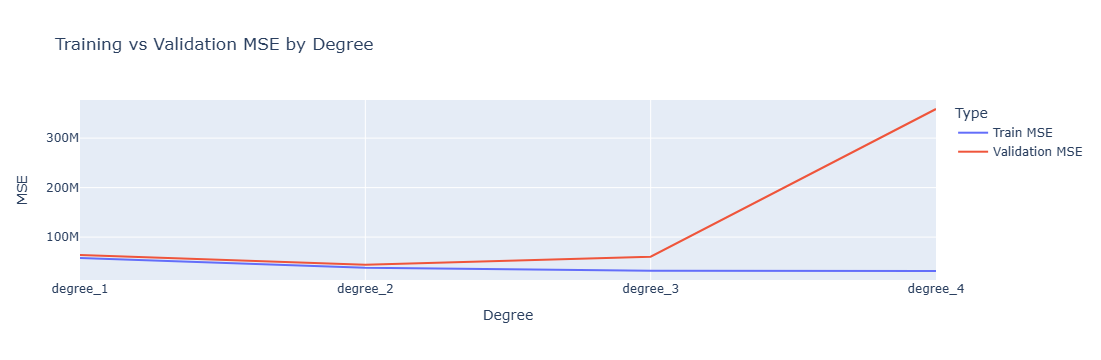

In [315]:
#understand how test and train mse vary with polynomial degree
linear_mse_scores = pd.DataFrame({
    'Degree': list(cv_scores_train.keys()),
    'Train MSE': list(cv_scores_train.values()),
    'Validation MSE': list(cv_scores_val.values())
})
fig1 = px.line(linear_mse_scores.melt(id_vars = 'Degree', var_name = 'Type', value_name = 'MSE'),
               x = 'Degree', y = 'MSE', color = 'Type', title = 'Training vs Validation MSE by Degree')
fig1.show()

As we can see, we achieve best validation MSE in the 2nd degree models but we will use the 2nd degree as the standard going forward. Now we can try to fine tune the linear regression through feature selection, or by selecting the features we thought would be critical based on the correlation matrix

In [771]:
#see how predicts do against actual data points
linear_pipe_1_deg = Pipeline([
    ('processer_1',preprocessor),
    ('linreg_1',LinearRegression())
])

#fit the pipeline to get prediction data
linear_pipe_1_deg.fit(X_train, y_train)
X_train_preds_1_deg = linear_pipe_1_deg.predict(X_train)
X_val_preds_1_deg = linear_pipe_1_deg.predict(X_val)

In [773]:
#see how predicts do against actual data points
linear_pipe_2_deg = Pipeline([
    ('processer_2',preprocessor),
    ('poly',PolynomialFeatures(degree = 2, include_bias=False)),
    ('linreg_2',LinearRegression())
])

#fit the pipeline to get prediction data
linear_pipe_2_deg.fit(X_train, y_train)
X_train_preds_2_deg = linear_pipe_2_deg.predict(X_train)
X_val_preds_2_deg = linear_pipe_2_deg.predict(X_val)

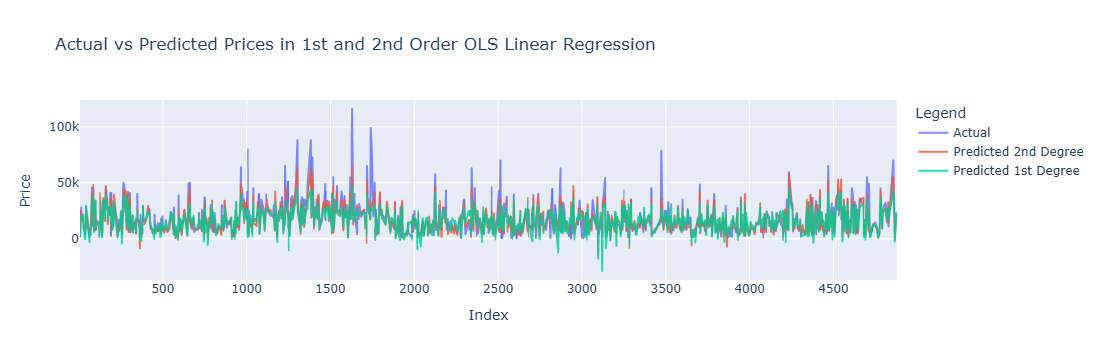

In [775]:
#Plot the predicted vs actuals to understand the shape of the prediction model
linear_plot_data = pd.DataFrame({
    'Index': y_val.index,
    'Actual': y_val,
    'Predicted 2nd Degree': X_val_preds_2_deg,
    'Predicted 1st Degree': X_val_preds_1_deg
})
linear_plot_data = linear_plot_data.sort_values(by='Index')

linear_plot_data_subset = linear_plot_data.head(1000)
fig2 = px.line(
    linear_plot_data_subset,
    x = 'Index',
    y = ['Actual','Predicted 2nd Degree', 'Predicted 1st Degree'],
    labels = {'value':'Price','variable':'Legend'},
    title = 'Actual vs Predicted Prices in 1st and 2nd Order OLS Linear Regression'
)
fig2.update_traces(opacity = 0.8)
fig2.show()

Both regressions do a pretty good job of following the general trend of pricing, however there are still improvements to be made. The first order OLS generally misses the spikes so it can't account for the combined factors that make a car more valuable to the consumer that the 2nd order can capture (e.g., low miles and a super car). These linear regressions also predicted some negative prices which we know shouldn't be true (1st order predicting more negative prices than 2nd order), and also has a large validation MSE which we can hopefully improve. We should also look at the coefficients to see which have the biggest impact for the two regressions, we can possibly use this to fine tune our models in the future.

In [777]:
#we also want to see the coefficients and their features to understand what has the biggest impact in the 1st degree linear model
linear_1_coeff = linear_pipe_1_deg.named_steps['linreg_1'].coef_

ohe_names = preprocessor.transformers_[0][1].get_feature_names_out(categorical_features)
all_feature_names = list(ohe_names) + numeric_features

linear_coefficients_mapping = list(zip(all_feature_names, linear_1_coeff))

sorted_linear_coeff = sorted(linear_coefficients_mapping, key = lambda x: x[1])

for feature, coef, in sorted_linear_coeff:
    if coef > 2000 or coef < -2000:
        print(f' Feature: {feature}, Coefficient: {coef}')

 Feature: manufacturer_category_foreign, Coefficient: -12351.135850969305
 Feature: manufacturer_category_other, Coefficient: -11941.51687330826
 Feature: manufacturer_category_domestic, Coefficient: -11591.002667515346
 Feature: manufacturer_category_foreign luxury, Coefficient: -9145.076725933608
 Feature: manufacturer_category_domestic luxury, Coefficient: -9089.099449097625
 Feature: age, Coefficient: -5674.229123502691
 Feature: fuel_gas, Coefficient: -4794.848227119182
 Feature: fuel_hybrid, Coefficient: -4023.2895347962476
 Feature: type_category_compact, Coefficient: -3693.6406824037963
 Feature: drive_fwd, Coefficient: -3389.180035146513
 Feature: title_status_parts only, Coefficient: -2962.256211615629
 Feature: type_category_SUV, Coefficient: -2756.137215500559
 Feature: odometer, Coefficient: -2448.6237367686526
 Feature: drive_4wd, Coefficient: 2053.345371289303
 Feature: fuel_electric, Coefficient: 2302.445186810972
 Feature: type_category_convertible, Coefficient: 2549.3

With the first order OLS, we get some idea of whats important here. Expected impacts are being a budget car (foreign or domestic) has a negative impact to the price (\\$12 and 11K lower respectively), age (\\$6K swing for every 5 years older or newer than 13 years old), and odometer (\\$2.3K swing for every 78K miles above or below the average of 110K). Positive impacts that are expected are being a super car (\\$54K positive impact) or a truck (\\$3.7K positive impact), having a clean title (\\$2K impact) or being electricly powered (\\$2.3K impact). However some unexpected results came like title status lien (\\$3.4K positive impact, maybe because it's a repossesed car so more likely to be new), manual having a positive impact (\\$1.1K possibly because manual is more rare and may be more likely to be on super cars or classic cars), and luxury foreign and domestic having a negative impact (likely because super cars manufacturer has such a positive impact on the pricing so the difference between budget and luxury distinguishes the impact of having luxury brands).

In [781]:
#we also want to see the coefficients and their features to understand what has the biggest impact in the 2nd degree linear model
linear_2_coeff = linear_pipe_2_deg.named_steps['linreg_2'].coef_

poly = linear_pipe_2_deg.named_steps['poly']
poly_feature_names = poly.get_feature_names_out(all_feature_names)

linear_coefficients_mapping = list(zip(poly_feature_names, linear_2_coeff))

sorted_linear_coeff = sorted(linear_coefficients_mapping, key = lambda x: x[1])

for feature, coef, in sorted_linear_coeff:
    #remove coefficients with 0 for features like (red x yellow) since they don't tell us anything, above 8000 to just examine the most impactful
    if coef != 0 and coef < -6500 or coef > 6500:
        print(f' Feature: {feature}, Coefficient: {coef}')

 Feature: manufacturer_category_super paint_color_black, Coefficient: -26108.474003612904
 Feature: manufacturer_category_super paint_color_grey, Coefficient: -19576.206276058954
 Feature: manufacturer_category_super odometer, Coefficient: -16837.71921271011
 Feature: fuel_electric title_status_lien, Coefficient: -15030.742807192637
 Feature: manufacturer_category_super paint_color_blue, Coefficient: -11587.792502875533
 Feature: fuel_hybrid paint_color_purple, Coefficient: -10609.870147341333
 Feature: title_status_lien paint_color_purple, Coefficient: -8293.078744772216
 Feature: manufacturer_category_domestic paint_color_silver, Coefficient: -7744.19794299543
 Feature: manufacturer_category_foreign luxury paint_color_silver, Coefficient: -7260.926326038091
 Feature: fuel_electric drive_fwd, Coefficient: -7259.94743899058
 Feature: manufacturer_category_domestic luxury paint_color_silver, Coefficient: -7213.341306551497
 Feature: manufacturer_category_domestic luxury type_category_tr

When we look at the 2nd degree OLS, we see some confounding factors that make cars more valuable. For example, being a super car with silver paint has a \$32K positive impact, as does a super car that's compact (\\$8K positive), and luxury brands painted black (\\$4-5K). However domestic and foreign budget cars get a greater boost to price by being painted black. We also see large negative impacts from certain combinations like any car with odometer, any car that uses gas, etc. We also see some splits based on car type that are quite interesting, e.g., most manufacturer types with age will be negatively impacted (i.e., older cars will have lower predicted prices) but that's not true with super cars which increase in price with increasing age, likely due to those cars being considered "classics" or collectors. **In general, it's obvious that certain classifications of cars (especially super cars) behave differently with different characteristics so it may be more useful and more interpretable to split the data out by car type or manufacturer type to understand what makes each of those types of cars priced higher or lower.**

**Next steps are to reduce the number of variables we're regressing on to hopefully improve accuracy or at least make the model easier to interpret. After that we can try Ridge and Lasso to create a penalty term which will hopefully reduce the amount of negative predictions**

In [334]:
selector = SequentialFeatureSelector(LinearRegression(), n_features_to_select=7)

In [336]:
#build pipeline with sequential features selected before polynomial features to decrease computational load
linear_pipe_select = Pipeline([
    ('processor',preprocessor),
    ('selector',selector),
    ('poly',PolynomialFeatures(degree = 2, include_bias=False)),
    ('linreg',LinearRegression()),
])

linear_pipe_select.fit(X_train, y_train)
train_mse_select = mean_squared_error(y_train, linear_pipe_select.predict(X_train))
val_mse_select = mean_squared_error(y_val, linear_pipe_select.predict(X_val))
print(f'train mse: {train_mse_select}')
print(f'val mse: {val_mse_select}')

train mse: 45325722.5142875
val mse: 51189982.9451501


In [783]:
#understand which features were selected by the selector
X_processed = preprocessor.transform(X_train)
selected_indices = selector.get_support(indices=True)

# Map selected indices to feature names
selected_feature_names = [all_feature_names[i] for i in selected_indices]
print(f'Selected feature names: {selected_feature_names}')

Selected feature names: ['manufacturer_category_super', 'fuel_diesel', 'drive_fwd', 'type_category_convertible', 'type_category_truck', 'odometer', 'age']


Doing feature selection did not improve the MSE and also did not really decrease the computational time required, but it did reiterate which features are likely the most impactful on the model, a lot of which we expect - odometer and age for sure, and whether the car is a truck or convertible (typically more expensive), whether it's a super car (usually substantially more expensive) and the fuel and drive type. However, we'd already learned these from the coefficients of the 1st order OLS without feature selection.

In [342]:
#Determine best ridge alpha using gridsearch and iterate to determine lowest MSE, had to run this multiple times to narrow in on best alpha score
param_dict = {'ridge__alpha': np.logspace(-4,4,25)}
pipe_ridge = Pipeline([
    ('preprocessor', preprocessor),
    ('ridge',Ridge()),
])
grid_ridge = GridSearchCV(pipe_ridge,param_grid=param_dict, scoring = 'neg_mean_squared_error')
grid_ridge.fit(X_train,y_train)
best_alpha = grid_ridge.best_params_['ridge__alpha']
train_preds_ridge = grid_ridge.predict(X_train)
val_preds_ridge = grid_ridge.predict(X_val)
ridge_mse_train = mean_squared_error(y_train,train_preds_ridge)
ridge_mse_val = mean_squared_error(y_val,val_preds_ridge)
print(f'ridge train mse: {ridge_mse_train}')
print(f'ridge val mse: {ridge_mse_val}')
print(f'best alpha: {best_alpha}')

ridge train mse: 57542164.37154754
ridge val mse: 63624162.51045606
best alpha: 0.46415888336127775


Best alpha was found at 0.46, however this is quite close to zero and shows that the ridge is quite close to the original OLS linear regression model, and as expected the MSEs are nearly identical. This means that regularization effect of the penalty term is weak and because training and validation MSEs are similar, the model is likely not overfitting on OLS. 

In [346]:
#try running ridge with second order polynomial to improve on our best OLS
pipe_ridge_2 = Pipeline([
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(degree = 2, include_bias=False)),
    ('ridge',Ridge())
])

grid_ridge_2 = GridSearchCV(pipe_ridge_2, param_grid=param_dict, scoring = 'neg_mean_squared_error')
grid_ridge_2.fit(X_train, y_train)
best_alpha_2 = grid_ridge_2.best_params_['ridge__alpha']
print(f'best alpha: {best_alpha_2}')

best alpha: 10.0


In [348]:
#now run ridge model with the best hyperparameter and determine MSE of ridge model
pipe_ridge_2_best = Pipeline([
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(degree = 2, include_bias=False)),
    ('ridge',Ridge(alpha = best_alpha_2))
])

pipe_ridge_2_best.fit(X_train, y_train)
train_preds_ridge_2 = pipe_ridge_2_best.predict(X_train)
val_preds_ridge_2 = pipe_ridge_2_best.predict(X_val)
ridge_mse_train_2 = mean_squared_error(y_train,train_preds_ridge_2)
ridge_mse_val_2 = mean_squared_error(y_val,val_preds_ridge_2)
print(f'ridge train mse: {ridge_mse_train_2}')
print(f'ridge val mse: {ridge_mse_val_2}')

ridge train mse: 37985958.38611279
ridge val mse: 43940743.5465082


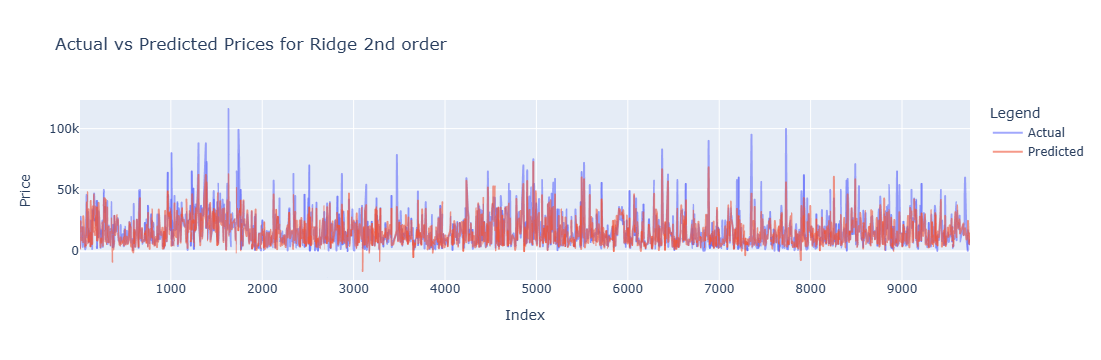

In [785]:
#Plot the predicted vs actuals to understand the shape of the prediction model and see how it compares to the linear
ridge_plot_data = pd.DataFrame({
    'Index': y_val.index,
    'Actual': y_val,
    'Predicted': val_preds_ridge_2
})
ridge_plot_data = ridge_plot_data.sort_values(by='Index')

ridge_plot_data_subset = ridge_plot_data.head(2000)
fig3 = px.line(
    ridge_plot_data_subset,
    x = 'Index',
    y = ['Actual','Predicted'],
    labels = {'value':'Price','variable':'Legend'},
    title = 'Actual vs Predicted Prices for Ridge 2nd order'
)
fig3.update_traces(opacity = 0.6)
fig3.show()

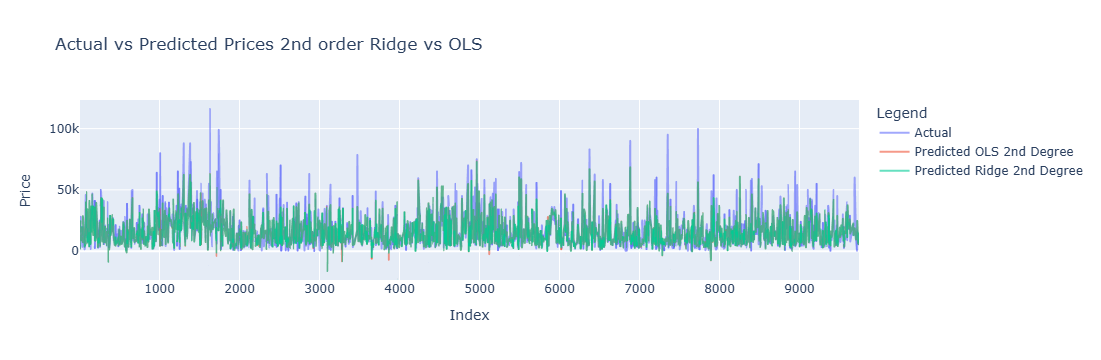

In [787]:
#compare 2nd order ridge vs. OLS
ridge_OLS_plot_data = pd.DataFrame({
    'Index': y_val.index,
    'Actual': y_val,
    'Predicted OLS 2nd Degree': X_val_preds_2_deg,
    'Predicted Ridge 2nd Degree': val_preds_ridge_2
})
ridge_OLS_plot_data = ridge_OLS_plot_data.sort_values(by='Index')

ridge_OLS_plot_data_subset = ridge_OLS_plot_data.head(2000)
fig4 = px.line(
    ridge_OLS_plot_data_subset,
    x = 'Index',
    y = ['Actual','Predicted OLS 2nd Degree','Predicted Ridge 2nd Degree'],
    labels = {'value':'Price','variable':'Legend'},
    title = 'Actual vs Predicted Prices 2nd order Ridge vs OLS'
)
fig4.update_traces(opacity = 0.6)
fig4.show()

After performing a Ridge regression on the data, with hyperparameters close to 0 and almost identical MSEs between OLS and Ridge (with the same polynomial degree) it isn't necessary to do a ridge regression because it will be harder to interpret than doing a standard OLS. it's nearly imperceptible in the outputs to see differences between OLS and ridge and we see even more negative predictions from ridge than we do with OLS.

In [794]:
#Without reducing our dataset significantly and/or doing PCA to reduce our features (impacting interpretability) we have to do lasso individually for
#different alpha values. Starting with Alpha = 1 we want to determine if lasso can get us more accurate than OLS.
pipe_lasso_2_deg = Pipeline([
    ('preprocessor',preprocessor),
    ('poly', PolynomialFeatures(degree = 2, include_bias=False)),
    ('lasso',Lasso(alpha = 1.0, max_iter = 1000))
])

pipe_lasso_2_deg.fit(X_train, y_train)

train_preds_lasso = pipe_lasso_2_deg.predict(X_train)
val_preds_lasso = pipe_lasso_2_deg.predict(X_val)

train_mse_lasso = mean_squared_error(y_train, train_preds_lasso)
val_mse_lasso = mean_squared_error(y_val, val_preds_lasso)

print(f'Lasso train MSE: {train_mse_lasso}')
print(f'Lasso validation MSE: {val_mse_lasso}')

C:\Users\Doug Watts\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:639: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 474806188783.29675, tolerance: 903762927.6841928



Lasso train MSE: 38127642.54436246
Lasso validation MSE: 43877497.18093332


In [796]:
#test lasso with alpha of 0.1. Tried to use gridsearch but it was too computationally taxing. Even running 1 lasso model with these parameters is taxing
pipe_lasso_2_deg = Pipeline([
    ('preprocessor',preprocessor),
    ('poly', PolynomialFeatures(degree = 2, include_bias=False)),
    ('lasso',Lasso(alpha = .10, max_iter = 1000))
])

pipe_lasso_2_deg.fit(X_train, y_train)

train_preds_lasso = pipe_lasso_2_deg.predict(X_train)
val_preds_lasso = pipe_lasso_2_deg.predict(X_val)

train_mse_lasso = mean_squared_error(y_train, train_preds_lasso)
val_mse_lasso = mean_squared_error(y_val, val_preds_lasso)

print(f'Lasso train MSE: {train_mse_lasso}')
print(f'Lasso validation MSE: {val_mse_lasso}')

C:\Users\Doug Watts\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:639: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 706343514410.9854, tolerance: 903762927.6841928



Lasso train MSE: 37860770.35470798
Lasso validation MSE: 43926841.820332095


In [798]:
#test lasso with alpha 10
pipe_lasso_2_deg = Pipeline([
    ('preprocessor',preprocessor),
    ('poly', PolynomialFeatures(degree = 2, include_bias=False)),
    ('lasso',Lasso(alpha = 10, max_iter = 1000))
])

pipe_lasso_2_deg.fit(X_train, y_train)

train_preds_lasso = pipe_lasso_2_deg.predict(X_train)
val_preds_lasso = pipe_lasso_2_deg.predict(X_val)

train_mse_lasso = mean_squared_error(y_train, train_preds_lasso)
val_mse_lasso = mean_squared_error(y_val, val_preds_lasso)

print(f'Lasso train MSE: {train_mse_lasso}')
print(f'Lasso validation MSE: {val_mse_lasso}')

Lasso train MSE: 39844363.05334721
Lasso validation MSE: 45950685.936544


In [803]:
#test lasso with alpha = 3
pipe_lasso_2_deg = Pipeline([
    ('preprocessor',preprocessor),
    ('poly', PolynomialFeatures(degree = 2, include_bias=False)),
    ('lasso',Lasso(alpha = 3, max_iter = 1000))
])

pipe_lasso_2_deg.fit(X_train, y_train)

train_preds_lasso = pipe_lasso_2_deg.predict(X_train)
val_preds_lasso = pipe_lasso_2_deg.predict(X_val)

train_mse_lasso = mean_squared_error(y_train, train_preds_lasso)
val_mse_lasso = mean_squared_error(y_val, val_preds_lasso)

print(f'Lasso train MSE: {train_mse_lasso}')
print(f'Lasso validation MSE: {val_mse_lasso}')

C:\Users\Doug Watts\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:639: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 49484163327.4436, tolerance: 903762927.6841928



Lasso train MSE: 38498348.6924584
Lasso validation MSE: 44219042.3829628


Lasso also doesn't get to a better MSE, with a best alpha around 1 suggesting not a lot of regularization and likely selecting the features we've already highlighted through OLS and Ridge. At this point it's time to assess how our models are doing and refine.

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

We've seen now OLS, Ridge, and Lasso regressions on the whole data set. 2nd degree polynomial expansion provides the lowest MSE with OLS while also remaining fairly interpretable, but I think we can improve on interpretability to make this model (or models) more useful for the dealers.

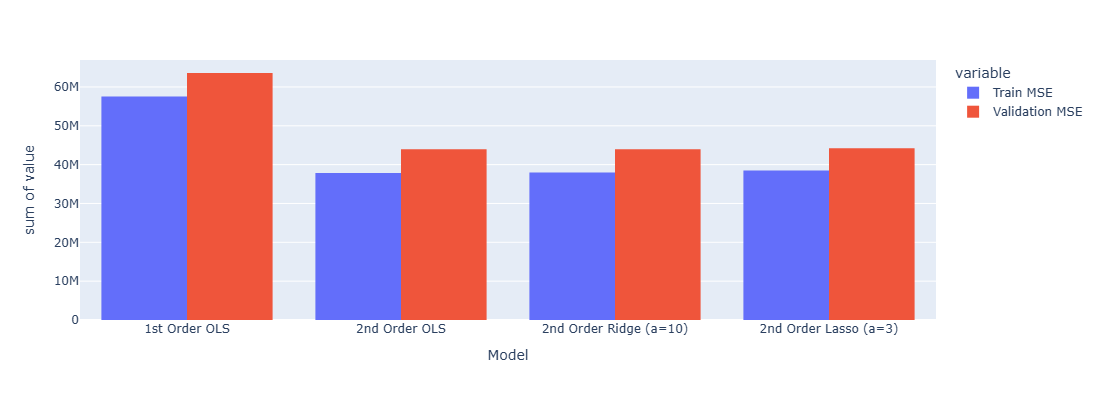

In [804]:
#bar plot to show comparison of MSE by model type
model_names = ['1st Order OLS', '2nd Order OLS','2nd Order Ridge (a=10)','2nd Order Lasso (a=3)']
train_mse = [cv_scores_train[f'degree_{1}'], cv_scores_train[f'degree_{2}'],ridge_mse_train_2,train_mse_lasso]
val_mse = [cv_scores_val[f'degree_{1}'], cv_scores_val[f'degree_{2}'],ridge_mse_val_2,val_mse_lasso]
mse_scores = pd.DataFrame({
    'Model': model_names,
    'Train MSE': train_mse,
    'Validation MSE': val_mse
})

fig4 = px.histogram(mse_scores, x = 'Model', y = ['Train MSE', 'Validation MSE'], barmode = 'group', height = 400)
fig4.show()

Because validation MSE is about the same for OLS, Ridge, and Lasso at 38-39M, I'm opting to keep linear regression for the ease of interpretation without needing to pull coefficients out and use the coefficients without a penalty term.

**However, in thinking about how to make this model useful for a dealer, I think rather than looking at all cars in combination, it's more useful for a dealer to understand what factors are most important for which type of vehicle.** If the dealer knows which cars sell for the most, they can focus on those cars, but because a dealer is unlikely to want to just sell one type of car, it's more useful for the dealer to understand for each category of vehicle, what features are most valuable for that type of vehicle. For example, that means being able to focus on specific features in a category like the color red for super cars but can also focus on cars that are black for foreign luxury vehicles. **This means creating and evaluating separate models for each kind of car. I think this makes most sense by either splitting by car type (e.g., truck, sedan, etc.) or by brand category (e.g., domestic, foreign, luxury, super). As far as interpretability goes, it's probably easiest and most useful to understand based on budget so it makes sense to run 3 separate models on budget, luxury, and super.**

### Modeling, revisited

In [361]:
#create budget, luxury, and super datasets
df_final_budget = df_final[(df_final['manufacturer_category'] == 'foreign') | (df_final['manufacturer_category'] == 'domestic')]
df_final_luxury = df_final[(df_final['manufacturer_category'] == 'foreign luxury') | (df_final['manufacturer_category'] == 'domestic luxury')]
df_final_super = df_final[df_final['manufacturer_category'] == 'super']

In [400]:
#check datasets
print(df_final_budget.info())
print(df_final_luxury.info())
print(df_final_super.info())

<class 'pandas.core.frame.DataFrame'>
Index: 88534 entries, 0 to 103655
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price                  88534 non-null  int64  
 1   fuel                   88534 non-null  object 
 2   odometer               88534 non-null  float64
 3   title_status           88534 non-null  object 
 4   transmission           88534 non-null  object 
 5   drive                  88534 non-null  object 
 6   paint_color            88534 non-null  object 
 7   age                    88534 non-null  float64
 8   manufacturer_category  88534 non-null  object 
 9   condition_numeric      88534 non-null  int8   
 10  type_category          88534 non-null  object 
dtypes: float64(2), int64(1), int8(1), object(7)
memory usage: 7.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 15067 entries, 9 to 103659
Data columns (total 11 columns):
 #   Column                 Non-Null C

In [722]:
#because we've split the data, there's not enough luxury electric cars to accurately model and it will show up in the coefficients later
#so, we remove electric cars from the luxury brands because it skews the influence of each component
df_final_luxury = df_final_luxury[df_final_luxury['fuel'] != 'electric']

In [724]:
print(df_final_budget.describe())
print(df_final_luxury.describe())

               price      odometer           age  condition_numeric
count   88534.000000  8.853400e+04  88534.000000       88534.000000
mean    14117.481386  1.186784e+05     13.521416           2.706813
std     12063.635742  7.759499e+04      5.637688           0.738687
min       101.000000  0.000000e+00      2.000000           0.000000
25%      5990.000000  7.390300e+04      9.000000           2.000000
50%     10000.000000  1.150000e+05     13.000000           3.000000
75%     18500.000000  1.554888e+05     17.000000           3.000000
max    195000.000000  2.621720e+06     30.000000           5.000000
               price      odometer           age  condition_numeric
count   15052.000000  1.505200e+04  15052.000000       15052.000000
mean    15466.950306  1.067102e+05     13.960803           2.788334
std     12509.881535  7.975124e+04      5.348445           0.705137
min       123.000000  0.000000e+00      3.000000           0.000000
25%      6995.000000  6.456900e+04     10.000000

In [726]:
df_final_budget.reset_index()
df_final_luxury.reset_index()

,index,price,fuel,odometer,title_status,transmission,drive,paint_color,age,manufacturer_category,condition_numeric,type_category
0,9,6000,diesel,124000.0,clean,automatic,rwd,blue,17.0,foreign luxury,2,compact
1,11,24590,gas,16081.0,clean,automatic,fwd,white,6.0,domestic luxury,2,compact
2,13,28000,gas,55000.0,clean,automatic,fwd,white,6.0,foreign luxury,3,compact
3,16,12950,gas,69586.0,clean,automatic,rwd,white,19.0,foreign luxury,3,convertible
4,25,19950,gas,80190.0,clean,automatic,rwd,red,15.0,foreign luxury,3,convertible
...,...,...,...,...,...,...,...,...,...,...,...,...
15047,103654,37590,gas,16482.0,clean,automatic,rwd,black,6.0,foreign luxury,2,SUV
15048,103656,39990,gas,41664.0,clean,automatic,4wd,black,7.0,foreign luxury,2,other
15049,103657,32990,gas,55612.0,clean,automatic,rwd,black,8.0,foreign luxury,2,other
15050,103658,30990,gas,15080.0,clean,automatic,rwd,white,6.0,foreign luxury,2,other


We now have 88K vehicles for a model for budget vehicles, and 15K vehicles for a model for luxury vehicles. We also only have 21 super vehicles for a model for super cars, which is too small to make an accurate model and also shows that super car sales are very rare for these types of dealers and maybe not worth our time or attention to figure out what makes a higher selling super car from just these factors (when there may be other very specific reasons why one super car is worth more than another) where the variance is high in each data point. We also see that luxury brand cars only sell for slightly higher average than the budget brand cars which could point to a misclassification of certain vehicles as 'budget' (e.g., Ford and Chevy, two of the most represented brands in the dataset both sell highly popular and expensive trucks) but we'll keep this classification for now as a useful exercise. 

In [730]:
#prepare data for modeling. We will no longer use a validation and testing split and just keep the datasets to training and validation because
#we will only be usign OLS models as it was determined to be the most useful in the previous exercise with the full data set.
budget_X_train, budget_X_test, budget_y_train, budget_y_test = (
    train_test_split(df_final_budget.drop('price',axis=1), df_final_budget['price'], test_size = 0.2))

luxury_X_train, luxury_X_test, luxury_y_train, luxury_y_test = (
    train_test_split(df_final_luxury.drop('price',axis=1), df_final_luxury['price'], test_size = 0.2))

In [732]:
#Because we're now using different onehot inputs (just domestic and foreign, no luxury or super, we need separate preprocessors for less data in onehot
preprocessor_budget = ColumnTransformer([
    ('cat', OneHotEncoder(), categorical_features),
    ('num', StandardScaler(), numeric_features)
])

#make preprocessor for luxury as well
preprocessor_luxury = ColumnTransformer([
    ('cat', OneHotEncoder(), categorical_features),
    ('num', StandardScaler(), numeric_features)
])

In [734]:
#now we run a second order OLS against each of these to make our models
#budget
budget_pipe = Pipeline([
    ('preprocesser_budget',preprocessor_budget),
    ('poly_budget',PolynomialFeatures(degree = 2, include_bias=False)),
    ('linreg_budget',LinearRegression())
])

budget_pipe.fit(budget_X_train, budget_y_train)

budget_preds_train = budget_pipe.predict(budget_X_train)
budget_preds_test = budget_pipe.predict(budget_X_test)
budget_train_MSE = mean_squared_error(budget_y_train, budget_preds_train)
budget_test_MSE = mean_squared_error(budget_y_test, budget_preds_test)
print(f'budget train MSE: {budget_train_MSE}')
print(f'budget test MSE: {budget_test_MSE}')

#luxury
luxury_pipe = Pipeline([
    ('processer_luxury',preprocessor_luxury),
    ('poly_luxury',PolynomialFeatures(degree = 2, include_bias=False)),
    ('linreg_luxury',LinearRegression())
])

luxury_pipe.fit(luxury_X_train, luxury_y_train)

luxury_preds_train = luxury_pipe.predict(luxury_X_train)
luxury_preds_test = luxury_pipe.predict(luxury_X_test)
luxury_train_MSE = mean_squared_error(luxury_y_train, luxury_preds_train)
luxury_test_MSE = mean_squared_error(luxury_y_test, luxury_preds_test)
print(f'luxury train MSE: {luxury_train_MSE}')
print(f'luxury test MSE: {luxury_test_MSE}')

budget train MSE: 35738144.807856336
budget test MSE: 37729489.29750919
luxury train MSE: 52997657.608225234
luxury test MSE: 63411835.760270245


Budget MSE is slightly better than the overall dataset MSE, while the luxury brand MSE is significantly higher than the overall dataset, so we should check on the luxury model to understand more, while also looking at the budget coefficients to interpret."

In [863]:
#now we can look at the coefficients for budget manufacturers, both first order and second order
budget_coeff = budget_pipe.named_steps['linreg_budget'].coef_

ohe_names_budget = preprocessor_budget.transformers_[0][1].get_feature_names_out(categorical_features)
all_feature_names_budget = list(ohe_names_budget) + numeric_features

poly_budget = budget_pipe.named_steps['poly_budget']
poly_feature_names_budget = poly_budget.get_feature_names_out(all_feature_names_budget)

budget_coefficients_mapping = list(zip(poly_feature_names_budget, budget_coeff))
first_order_budget_mapping = budget_coefficients_mapping[0:38]
second_order_budget_mapping = budget_coefficients_mapping[39:]

first_order_budget_coeff = sorted(first_order_budget_mapping, key = lambda x: abs(x[1]), reverse = True)
second_order_budget_coeff = sorted(second_order_budget_mapping, key = lambda x: abs(x[1]), reverse = True)

print('Top 10 First Order Features with largest impact on budget manufacturer prices:')
for feature, coef, in first_order_budget_coeff[0:10]:
        print(f'{feature}: ${round(coef)}')
print()
print('Top 15 Second Order Features with largest impact on budget manufacturers prices:')
for feature, coef, in second_order_budget_coeff[0:15]:
        print(f'{feature}: ${round(coef)}')

# Save the top 10 first-order coefficients
top_10_first_order_features_budget = [feature for feature, coef in first_order_budget_coeff[:10]]
top_10_first_order_values_budget = [coef for feature, coef in first_order_budget_coeff[:10]]

# Save the top 15 second-order coefficients
top_15_second_order_features_budget = [feature for feature, coef in second_order_budget_coeff[:15]]
top_15_second_order_values_budget = [coef for feature, coef in second_order_budget_coeff[:15]]

Top 10 First Order Features with largest impact on budget manufacturer prices:
title_status_parts only: $-2853
fuel_electric: $2433
age: $-1814
fuel_hybrid: $-1639
odometer: $-1468
drive_fwd: $-1446
drive_4wd: $1359
type_category_truck: $1226
type_category_convertible: $-1191
fuel_gas: $-1162

Top 15 Second Order Features with largest impact on budget manufacturers prices:
fuel_electric title_status_rebuilt: $10298
fuel_electric title_status_lien: $-8881
fuel_diesel title_status_parts only: $-8468
fuel_electric drive_fwd: $-7009
fuel_electric drive_4wd: $6316
fuel_hybrid paint_color_purple: $-6163
fuel_electric title_status_salvage: $5670
fuel_hybrid title_status_missing: $5622
fuel_gas title_status_parts only: $5615
fuel_diesel title_status_clean: $5481
fuel_diesel paint_color_purple: $5192
title_status_missing paint_color_purple: $5181
fuel_diesel type_category_convertible: $-5039
fuel_diesel type_category_compact: $-4913
title_status_lien paint_color_yellow: $4826


We now have our first look at what matters for budget manufacturers: the coefficients that are both first and second order with the highest impacts. For example, age alone has a \\$2K reduction in price for every 5 years over the age of 13 the car is. Or a $2K increase in price for every 5 years younger than 13 the car is. Cars with front wheel drive are negatively priced \\$1.7K below the average price of the budget manufacturer car, but 4wd increases value by \\$1.5K. Looking at second order coefficients is a little more complicated, but we can see that combinations like diesel compacts have a \\$5.5K reduction in price. Gas powered convertibles and diesel powered vans both increase value by almost \\$4K. 

In [865]:
#now we can look at the coefficients for budget manufacturers, both first order and second order
luxury_coeff = luxury_pipe.named_steps['linreg_luxury'].coef_

ohe_names_luxury = preprocessor_luxury.transformers_[0][1].get_feature_names_out(categorical_features)
all_feature_names_luxury = list(ohe_names_luxury) + numeric_features

poly_luxury = luxury_pipe.named_steps['poly_luxury']
poly_feature_names_luxury = poly_luxury.get_feature_names_out(all_feature_names_luxury)

luxury_coefficients_mapping = list(zip(poly_feature_names_luxury, luxury_coeff))
first_order_luxury_mapping = luxury_coefficients_mapping[0:38]
second_order_luxury_mapping = luxury_coefficients_mapping[39:]

first_order_luxury_coeff = sorted(first_order_luxury_mapping, key = lambda x: abs(x[1]), reverse = True)
second_order_luxury_coeff = sorted(second_order_luxury_mapping, key = lambda x: abs(x[1]), reverse = True)

print('Top 10 First Order Features with largest impact on luxury manufacturer prices:')
for feature, coef, in first_order_luxury_coeff[0:10]:
        print(f'{feature}: ${round(coef)}')
print()
print('Top 15 Second Order Features with largest impact on luxury manufacturers prices:')
for feature, coef, in second_order_luxury_coeff[0:15]:
        print(f'{feature}: ${round(coef)}')

# Save the top 10 first-order coefficients
top_10_first_order_features_luxury = [feature for feature, coef in first_order_luxury_coeff[:10]]
top_10_first_order_values_luxury = [coef for feature, coef in first_order_luxury_coeff[:10]]

# Save the top 15 second-order coefficients
top_15_second_order_features_luxury = [feature for feature, coef in second_order_luxury_coeff[:15]]
top_15_second_order_values_luxury = [coef for feature, coef in second_order_luxury_coeff[:15]]

Top 10 First Order Features with largest impact on luxury manufacturer prices:
type_category_convertible: $4301
age: $-2972
fuel_gas: $-2478
drive_4wd: $2241
type_category_other: $-2050
transmission_automatic: $-2038
transmission_manual: $2038
fuel_diesel: $1878
paint_color_purple: $1572
drive_fwd: $-1447

Top 15 Second Order Features with largest impact on luxury manufacturers prices:
drive_4wd type_category_van: $20015
fuel_diesel type_category_convertible: $19224
fuel_diesel type_category_other: $-16961
title_status_rebuilt type_category_other: $15370
fuel_gas type_category_other: $14912
type_category_van paint_color_silver: $-14644
type_category_truck paint_color_grey: $-14264
fuel_gas type_category_convertible: $-13551
type_category_van paint_color_black: $13456
type_category_van age: $-12941
drive_rwd type_category_van: $-12318
fuel_diesel type_category_van: $11264
fuel_gas type_category_van: $-10328
fuel_hybrid title_status_rebuilt: $9143
title_status_rebuilt type_category_truck

Here too we see what impacts the pricing of luxury brand cars the most. First order impacts are driven by whether the vehicle is a convertible, the age, whether it's gas powered, and if it's 4wd. We see second order impacts that are combinations like 4wd vans are particularly higher value than average (by \\$20K).

**We now have some numbers to deploy and can influence the strategy of which cars to have on the lot for the dealer!**

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

**Manufacturer Grouping:**
In order to make this data useful, manufacturers have been grouped according to "budget" or "luxury" in order to be more precise in understanding which cars are best to have on the lot to attract the best sales price. The groupings are determined below wehre 'budget' brands are either Domestic or Foreign, and 'luxury' brands are either Domestic Luxury or Foreign Luxury. Super car manufacturers were excluded from the data analysis as there was not enough data to be useful.

In [817]:
from collections import defaultdict
grouped_manufacturers = defaultdict(list)
for manuf, category in manufacturer_mapping.items():
    grouped_manufacturers[category].append(manuf)

for category in ['domestic', 'domestic luxury', 'foreign','foreign luxury','super']:
    print(f'{category.title()}:')
    for manufacturer in sorted(grouped_manufacturers[category]):
        print(f' - {manufacturer}')
    print()

Domestic:
 - buick
 - chevrolet
 - chrysler
 - dodge
 - ford
 - gmc
 - jeep
 - mercury
 - pontiac
 - ram
 - saturn
 - tesla

Domestic Luxury:
 - cadillac
 - lincoln

Foreign:
 - fiat
 - honda
 - hyundai
 - jaguar
 - kia
 - mazda
 - mini
 - mitsubishi
 - nissan
 - rover
 - subaru
 - toyota
 - volkswagen

Foreign Luxury:
 - acura
 - alfa-romeo
 - audi
 - bmw
 - infiniti
 - land rover
 - lexus
 - mercedes-benz
 - porsche
 - volvo

Super:
 - aston-martin
 - ferrari



We need to set some baselines for what average and standard deviation are for price, odometer, age, and condition:

In [853]:
#price
budget_average_price = round(df_final_budget['price'].mean())
print(f'Average price of a budget car: ${budget_average_price}')
luxury_average_price = round(df_final_luxury['price'].mean())
print(f'Average price of a luxury car: ${luxury_average_price}')

Average price of a budget car: $14117
Average price of a luxury car: $15467


In [855]:
#odometer
budget_average_odo = round(df_final_budget['odometer'].mean())
print(f'Average odometer of a budget car: {budget_average_odo} miles')
budget_std_odo = round(df_final_budget['odometer'].std())
print(f'Standard Deviation of odometer of a budget car: {budget_std_odo} miles')

luxury_average_odo = round(df_final_luxury['odometer'].mean())
print(f'Average odometer of a luxury car: {luxury_average_odo} miles')
luxury_std_odo = round(df_final_luxury['odometer'].std())
print(f'Standard Deviation of odometer of a luxury car: {luxury_std_odo} miles')

Average odometer of a budget car: 118678 miles
Standard Deviation of odometer of a budget car: 77595 miles
Average odometer of a luxury car: 106710 miles
Standard Deviation of odometer of a luxury car: 79751 miles


In [851]:
#age
budget_average_age = round(df_final_budget['age'].mean())
print(f'Average age of a budget car: {budget_average_age} years')
budget_std_age = round(df_final_budget['age'].std())
print(f'Standard Deviation of age of a budget car: {budget_std_age} years')

luxury_average_age = round(df_final_luxury['age'].mean())
print(f'Average age of a luxury car: {luxury_average_age} years')
luxury_std_age = round(df_final_luxury['age'].std())
print(f'Standard Deviation of age of a luxury car: {luxury_std_age} years')

Average age of a budget car: 14 years
Standard Deviation of age of a budget car: 6 years
Average age of a luxury car: 14 years
Standard Deviation of age of a luxury car: 5 years


***Results*** <br>
**Budget Category** <br>
How the price of a car varies for budget cars is based on the numbers below

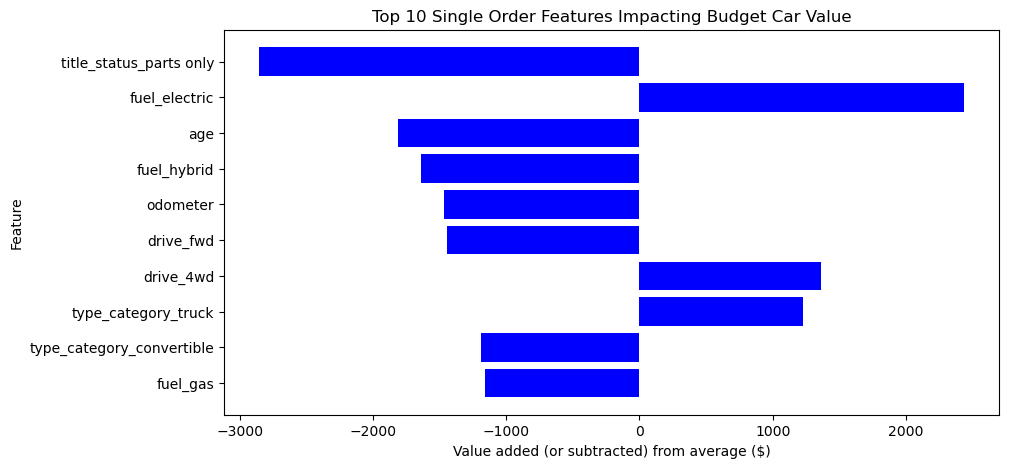

In [876]:
#look at single order features for budget cars
plt.figure(figsize=(10,5))
plt.barh(top_10_first_order_features_budget, top_10_first_order_values_budget, color = 'blue')
plt.xlabel('Value added (or subtracted) from average ($)')
plt.ylabel('Feature')
plt.title('Top 10 First Order Features Impacting Budget Car Value')
plt.gca().invert_yaxis()
plt.show()

For numerical values, like age or odometer, value can be determined by multiplying the impact (e.g., \\$2K for age) by the number of standard deviations above or below the average - for age of a budget car, if it's 2 years old, that would be 2 standard deviations below average so would increase the cars value above average by \\$4K. In looking for what cars to have on the lot it's most important to have a clean title (or at least not parts only), be electric, be young, not be a hybrid, have a lower odometer, be 4wd, and be a truck. These features have no confounding factors which we will see impacts car pricing below.

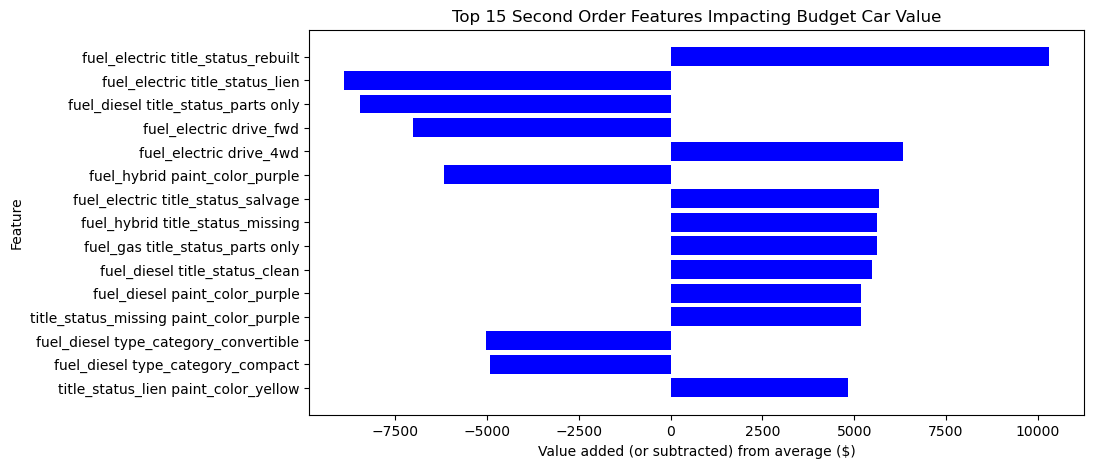

In [879]:
#look at second order features for budget cars
plt.figure(figsize=(10,5))
plt.barh(top_15_second_order_features_budget, top_15_second_order_values_budget, color = 'blue')
plt.xlabel('Value added (or subtracted) from average ($)')
plt.ylabel('Feature')
plt.title('Top 15 Second Order Features Impacting Budget Car Value')
plt.gca().invert_yaxis()
plt.show()

Here we can see that the largest impact on value from a 2nd order perspective is related to title status and fuel types. Before putting a car on the lot ensure it's title status and fuel type matches to one that has a higher impact on value. 

**Luxury Category** <br>
We can get a similar look at what factors drive value with the luxury brands as well

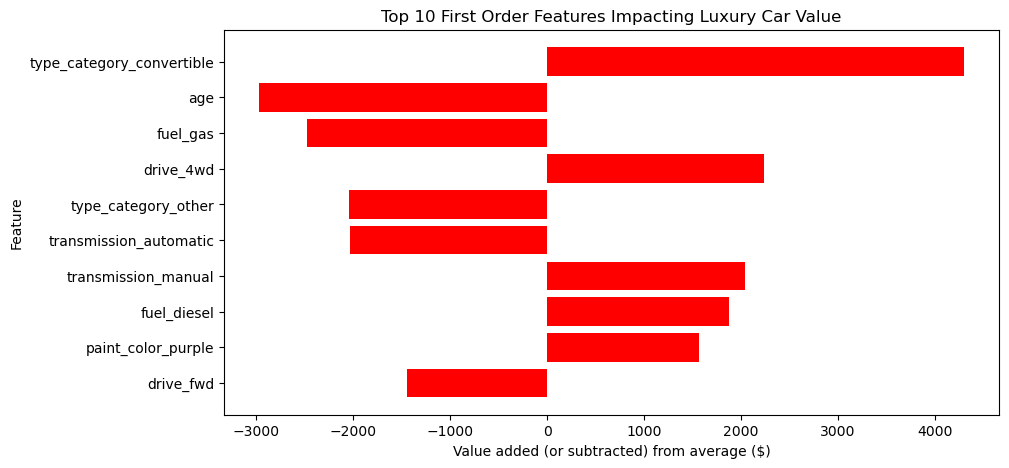

In [891]:
#look at single order features for luxury cars
plt.figure(figsize=(10,5))
plt.barh(top_10_first_order_features_luxury, top_10_first_order_values_luxury, color = 'red')
plt.xlabel('Value added (or subtracted) from average ($)')
plt.ylabel('Feature')
plt.title('Top 10 First Order Features Impacting Luxury Car Value')
plt.gca().invert_yaxis()
plt.show()

With luxury cars, most important impact is that the car is a convertible, so to increase the average cost of the car by \\$4.5K, we should be putting more luxury convertibles on the lot. Otherwise it's similar features to what you would expect. Younger, all wheel drive cars that run on diseal are more valuable than gas, automatic cars that are older. 

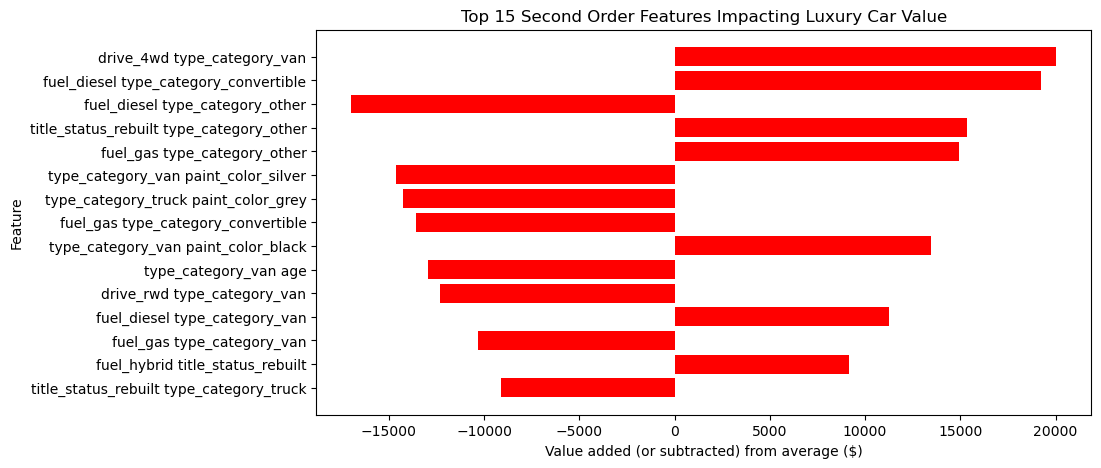

In [895]:
#look at second order features for budget cars
plt.figure(figsize=(10,5))
plt.barh(top_15_second_order_features_luxury, top_15_second_order_values_luxury, color = 'red')
plt.xlabel('Value added (or subtracted) from average ($)')
plt.ylabel('Feature')
plt.title('Top 15 Second Order Features Impacting Luxury Car Value')
plt.gca().invert_yaxis()
plt.show()

Much higher value from the luxury brands come in the form of specific vehicles. One great example is the all wheel drive van (e.g., Mercedes Sprinter) which are popular for both cargo carrying and for converting into camper vans for well-off clientale. We also see diesel convertibles (likely European brands), cars painted black, and younger vans also contibuting greatly to changes in price. Vans in particular have large changes in valuation depending on color, fuel type, age, and driving type (4wd or fwd). 